The purpose of this notebook is to make outcome predictions.

Future usage of the numerically encoded dataset may need to consider dropping a reference category so this reference case is encoded when all values are zero.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
# # the "1" means: always reload modules marked with "%aimport"
%autoreload 2

from __future__ import absolute_import, division, print_function
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os, sys
# from tqdm import tqdm
# import warnings

# sns.set_context("poster", font_scale=0.9)
sns.set_context("notebook", font_scale=1.0)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# add the data functions to the path
src_data_dir = os.path.join(os.getcwd(), os.pardir, 'src/data')
sys.path.append(src_data_dir)

# functions to load the data
import homeless_dataset as hd

In [2]:
# my gist from https://gist.github.com/warmlogic/afaf1d2b1ce90927d14f008571b6f6f0
import classify_utils as cu

In [3]:
datadir_raw = os.path.join(os.getenv('HOME'), 'Dropbox', 'C4SF-datasci-homeless', 'raw')
datadir_proc = os.path.join(os.getenv('HOME'), 'Dropbox', 'C4SF-datasci-homeless', 'processed')

In [4]:
# load the data

df_features = pd.read_csv(os.path.join(datadir_proc, '2017-01-22_homeless_summary_categorical_string.csv'), header=0, index_col=0)

In [5]:
df_features.describe()

,chronic_homeless,client_age_at_entry,continuously_homeless_one_year,days_enrolled,days_to_residential_move_in,disabling_condition,domestic_violence_victim,dv_currently_fleeing,enrollments,head_of_household,in_permanent_housing,months_ago_dv_occurred,months_homeless_this_time,times_homeless_past_three_years,times_in_permanent_housing,transsexual,veteran_status,noncash_benefit_tanfother,noncash_benefit_wic,noncash_benefit_publichousing,noncash_benefit_temprental,noncash_benefit_other,noncash_benefit_tanftransportation,noncash_benefit_tanfchildcare,noncash_benefit_foodstamps,health_insurance_medicaid,health_insurance_statechild,health_insurance_stateadult,health_insurance_veteranadmin,health_insurance_pirvate,health_insurance_employer,health_insurance_medicare,health_insurance_cobra,disability_type_alcohol,disability_type_alcoholdrug,disability_type_physical,disability_type_mentalhealth,disability_type_hearing,disability_type_dualdiagnosis,disability_type_developmental,disability_type_hivaids,disability_type_substance,disability_type_vision,disability_type_other,disability_type_chronichealth,disability_type_drug
count,11362.000000,11362.000000,11362.000000,11362.000000,747.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,1910.000000,1726.000000,5202.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000
mean,0.059849,33.622250,0.185443,207.853459,72.552878,0.390512,0.183154,0.001672,5.123130,0.409347,0.101039,16.102618,6.976246,1.346790,0.139236,0.002640,0.192836,0.005457,0.026844,0.014522,0.002728,0.019187,0.007481,0.006689,0.265094,0.329255,0.031421,0.026580,0.137828,0.008801,0.009593,0.076571,0.002200,0.027196,0.040222,0.100070,0.124538,0.000088,0.000088,0.020331,0.015842,0.000440,0.000264,0.000264,0.076219,0.034765
std,0.237217,20.246602,0.388673,330.189494,81.557515,0.487887,0.386810,0.040861,18.586563,0.491735,0.301393,9.192029,9.969520,1.122937,1.042184,0.051319,0.394543,0.073671,0.161634,0.119635,0.052165,0.137187,0.086173,0.081516,0.441403,0.469964,0.174459,0.160859,0.344734,0.093405,0.097479,0.265921,0.046858,0.162661,0.196488,0.300107,0.330209,0.009382,0.009382,0.141136,0.124871,0.020974,0.016248,0.016248,0.265360,0.183192
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,16.000000,0.000000,26.000000,16.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,34.000000,0.000000,96.000000,48.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,24.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,51.000000,0.000000,258.000000,97.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000,24.000000,12.000000,2.000000,0.000000,0.000000,0.000000,0.

# Run an overall logistic regression model for everyone together

In [6]:
# drop features that are related to the outcome

outcome = 'in_permanent_housing'
outcome_related = ['days_to_residential_move_in', 'times_in_permanent_housing']
# outcome_related = ['in_permanent_housing', 'days_to_residential_move_in', 'times_in_permanent_housing']

df_model = df_features.copy()

for col in outcome_related:
    if col in df_model.columns:
        df_model = df_model.drop(col, axis=1)

In [7]:
# fill in any missing values with the median for that column
for col, typ in df_model.dtypes.iteritems():
    if typ != 'object':
        df_model[[col]] = df_model[[col]].apply(lambda x: x.fillna(x.median()))

In [8]:
# drop some rows that make up few enough of certain categories that they cause issues with logistic regression

living_vals_drop = [
    'owned',
    'safehaven',
    'foster',
    'permanenthousing',
    'halfwayhouse',
    'ownedsubsidy',
    'longtermcare',
    'rentalgdptip',
]

df_model = df_model.loc[(df_model['gender'] != 'unknown') &
                        (df_model['housing_status_project_start'] != 'cat3homelessfedstatutes') &
                        (df_model['housing_status_project_start'] != 'cat4fleeingdv') &
                        (df_model['housing_status_project_start'] != 'housed') &
                        df_model['living_situation_before_program_entry'].apply(lambda x: False if x in living_vals_drop else True), :]

In [9]:
outcome = 'in_permanent_housing'

f = """
in_permanent_housing ~ client_age_at_entry 
+ chronic_homeless 
+ domestic_violence_victim 
+ disabling_condition 
+ veteran_status 
+ head_of_household 
+ C(gender) 
+ C(race) 
+ C(ethnicity) 
+ C(project_type_code) 
+ C(housing_status_project_start) 
+ C(living_situation_before_program_entry) 
+ continuously_homeless_one_year 
+ I(days_enrolled / (365.25 / 12))
+ dv_currently_fleeing 
+ enrollments 
+ months_ago_dv_occurred 
+ months_homeless_this_time 
+ times_homeless_past_three_years 
+ transsexual 
+ noncash_benefit_tanfother 
+ noncash_benefit_wic 
+ noncash_benefit_publichousing 
+ noncash_benefit_temprental 
+ noncash_benefit_other 
+ noncash_benefit_tanftransportation 
+ noncash_benefit_tanfchildcare 
+ noncash_benefit_foodstamps 
+ health_insurance_medicaid 
+ health_insurance_statechild 
+ health_insurance_stateadult 
+ health_insurance_veteranadmin 
+ health_insurance_pirvate 
+ health_insurance_employer 
+ health_insurance_medicare 
+ health_insurance_cobra 
+ disability_type_alcohol 
+ disability_type_alcoholdrug 
+ disability_type_chronichealth 
+ disability_type_developmental 
+ disability_type_drug 
+ disability_type_dualdiagnosis 
+ disability_type_hearing 
+ disability_type_hivaids 
+ disability_type_mentalhealth 
+ disability_type_physical 
"""

# these features are causing issues
# + disability_type_substance + disability_type_vision + disability_type_other 

results_log = cu.sm_logit(
    df_model,
    f=f,
    #maxiter=100,
    reg_method = 'l1',
    reg_alpha=0.1,
    )


in_permanent_housing ~ client_age_at_entry 
+ chronic_homeless 
+ domestic_violence_victim 
+ disabling_condition 
+ veteran_status 
+ head_of_household 
+ C(gender) 
+ C(race) 
+ C(ethnicity) 
+ C(project_type_code) 
+ C(housing_status_project_start) 
+ C(living_situation_before_program_entry) 
+ continuously_homeless_one_year 
+ I(days_enrolled / (365.25 / 12))
+ dv_currently_fleeing 
+ enrollments 
+ months_ago_dv_occurred 
+ months_homeless_this_time 
+ times_homeless_past_three_years 
+ transsexual 
+ noncash_benefit_tanfother 
+ noncash_benefit_wic 
+ noncash_benefit_publichousing 
+ noncash_benefit_temprental 
+ noncash_benefit_other 
+ noncash_benefit_tanftransportation 
+ noncash_benefit_tanfchildcare 
+ noncash_benefit_foodstamps 
+ health_insurance_medicaid 
+ health_insurance_statechild 
+ health_insurance_stateadult 
+ health_insurance_veteranadmin 
+ health_insurance_pirvate 
+ health_insurance_employer 
+ health_insurance_medicare 
+ health_insurance_cobra 
+ disability

In [10]:
cu.print_sm_logit_results(results_log);

,0,1,2,3
0,Model:,Logit,Pseudo R-squared:,0.487
1,Dependent Variable:,in_permanent_housing,AIC:,3589.1739
2,Date:,2017-01-24 22:46,BIC:,4117.7149
3,No. Observations:,10304,Log-Likelihood:,-1721.6
4,Df Model:,72,LL-Null:,-3355.4
5,Df Residuals:,10231,LLR p-value:,0.0000
6,Converged:,True,Scale:,1.0000
7,No. Iterations:,987.0000,,


As feature increases, more likely to be in positive class:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
C(project_type_code)[T.rapidrehousing],5.195651,180.485595,0.271686,19.123732,1.602238e-81,4.663156,5.728146
C(project_type_code)[T.homelessnessprevention],4.501064,90.112933,0.280253,16.060689,4.811766e-58,3.951777,5.050350
head_of_household,1.710804,5.533408,0.131269,13.032791,7.964063e-39,1.453521,1.968087
C(project_type_code)[T.servicesonly],2.901034,18.192956,0.251725,11.524612,9.915785e-31,2.407662,3.394407
health_insurance_statechild,2.279319,9.770021,0.219876,10.366391,3.525924e-25,1.848370,2.710267
I(days_enrolled / (365.25 / 12)),0.043071,1.044012,0.005038,8.549546,1.235738e-17,0.033197,0.052945
health_insurance_medicaid,0.929285,2.532698,0.122684,7.574655,3.600824e-14,0.688830,1.169740
health_insurance_stateadult,1.669770,5.310946,0.232982,7.166960,7.668131e-13,1.213134,2.126406
noncash_benefit_publichousing,1.559495,4.756417,0.287464,5.425013,5.795019e-08,0.996076,2.122913
health_insurance_veteranadmin,0.826252,2.284739,0.168950,4.890507,1.005765e-06,0.495116,1.157388



As feature increases, less likely to be in positive class:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-9.121856,9153.171052,0.870599,-10.477677,1.093980e-25,-10.828198,-7.415513
domestic_violence_victim,-0.872681,2.393318,0.201907,-4.322186,1.544905e-05,-1.268412,-0.476950
times_homeless_past_three_years,-0.259520,1.296307,0.066534,-3.900576,9.596428e-05,-0.389923,-0.129116
health_insurance_cobra,-4.278074,72.101416,1.122560,-3.810999,1.384065e-04,-6.478250,-2.077897
disabling_condition,-0.487213,1.627773,0.130694,-3.727886,1.930927e-04,-0.743369,-0.231057
noncash_benefit_wic,-1.615884,5.032337,0.435830,-3.707603,2.092304e-04,-2.470095,-0.761673
noncash_benefit_foodstamps,-0.395962,1.485813,0.118365,-3.345261,8.220518e-04,-0.627954,-0.163971
disability_type_hivaids,-2.454122,11.636211,0.800596,-3.065369,2.174018e-03,-4.023261,-0.884983
C(ethnicity)[T.nonlatino],-0.311759,1.365826,0.111708,-2.790830,5.257312e-03,-0.530704,-0.092815
disability_type_drug,-0.942316,2.565917,0.372190,-2.531812,1.134748e-02,-1.671795,-0.212836


# Run separate models for different groups

Use sklearn, with one-hot encoded categorical data

## Groups to predict permanent housing outcome

- veteran_status
- chronic_homeless
- continuously_homeless_one_year
- disabling_condition
- domestic_violence_victim
- gender_female
- gender_male
- ethnicity_latino
- ethnicity_nonlatino


In [11]:
df_features_num = pd.read_csv(os.path.join(datadir_proc, '2017-01-22_homeless_summary_categorical_numeric.csv'), header=0, index_col=0)

In [12]:
member_size_threshold=0.01

if member_size_threshold < 1:
    member_size_threshold = int(np.ceil(df_features_num.shape[0] * member_size_threshold))

cols_to_drop_few = df_features_num.columns[df_features_num.sum() < member_size_threshold].tolist()
print('Dropping these columns due to fewer than {} people having this:\n'.format(member_size_threshold), cols_to_drop_few)
df_features_num = df_features_num.drop(cols_to_drop_few, axis=1)

Dropping these columns due to fewer than 114 people having this:
 ['dv_currently_fleeing', 'gender_unknown', 'housing_status_project_start_cat3homelessfedstatutes', 'housing_status_project_start_cat4fleeingdv', 'living_situation_before_program_entry_foster', 'living_situation_before_program_entry_halfwayhouse', 'living_situation_before_program_entry_longtermcare', 'living_situation_before_program_entry_ownedsubsidy', 'living_situation_before_program_entry_rentalgdptip', 'transsexual', 'noncash_benefit_temprental', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation', 'health_insurance_pirvate', 'health_insurance_employer', 'health_insurance_cobra', 'disability_type_other', 'disability_type_dualdiagnosis', 'disability_type_substance', 'disability_type_hearing', 'disability_type_vision']


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# outcome = 'in_permanent_housing'
# outcome_related = ['in_permanent_housing', 'days_to_residential_move_in', 'times_in_permanent_housing',
#                    #'project_type_code_rapidrehousing',
#                    #'days_enrolled',
#                   ]
# y = df_model_num[outcome].values
# X = df_model_num.drop(outcome_related, axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# print('train', X_train.shape)
# print('test', X_test.shape)

In [15]:
# TEST. DELETE THIS.

# col = 'domestic_violence_victim'
# cols_to_drop = [col]

# df_model_num = df_features_num.copy()

# # fill in any missing values with the median for that column
# df_model_num = df_model_num.apply(lambda x: x.fillna(x.median()),axis=0)

# # df_model_num.describe()

# df_model_num = df_model_num.loc[df_model_num[col] == 1, :]
# df_model_num = df_model_num.drop(cols_to_drop, axis=1)

# n_member_threshold=20
# cols_to_drop_few = df_model_num.columns[df_model_num.sum() < n_member_threshold].tolist()

# df_model_num = df_model_num.drop(cols_to_drop_few, axis=1)



In [16]:
def run_lr_group(df_features_num, col, cols_to_drop,
                 test_size=0.33,
                 member_size_threshold=0.01,
                 print_n_features=20,
                ):
    print(col, '\n')
    
    #     # these columns have very few people
    #     cols_to_drop_few = [
    #         'gender_unknown',
    #         'housing_status_project_start_cat3homelessfedstatutes',
    #         'housing_status_project_start_cat4fleeingdv',
    #         'housing_status_project_start_housed',
    #         'living_situation_before_program_entry_owned',
    #         'living_situation_before_program_entry_safehaven',
    #         'living_situation_before_program_entry_foster',
    #         'living_situation_before_program_entry_permanenthousing',
    #         'living_situation_before_program_entry_halfwayhouse',
    #         'living_situation_before_program_entry_ownedsubsidy',
    #         'living_situation_before_program_entry_longtermcare',
    #         'living_situation_before_program_entry_rentalgdptip',
    #     ]

    df_model_num = df_features_num.copy()
    
    # df_model_num = df_model_num.drop(cols_to_drop_few, axis=1)
    
    # fill in any missing values with the median for that column
    df_model_num = df_model_num.apply(lambda x: x.fillna(x.median()),axis=0)

    # df_model_num.describe()
    
    df_model_num = df_model_num.loc[df_model_num[col] == 1, :]
    df_model_num = df_model_num.drop(cols_to_drop, axis=1)
    
    if member_size_threshold < 1:
        member_size_threshold = int(np.ceil(df_model_num.shape[0] * member_size_threshold))
    
    # drop columns where fewer than member_size_threshold have this
    cols_to_drop_few = df_model_num.columns[df_model_num.sum() < member_size_threshold].tolist()
    print('Dropping these columns due to fewer than {} people having this:\n'.format(member_size_threshold), cols_to_drop_few)
    df_model_num = df_model_num.drop(cols_to_drop_few, axis=1)

    outcome = 'in_permanent_housing'
    outcome_related = ['in_permanent_housing', 'days_to_residential_move_in', 'times_in_permanent_housing',
                       #'project_type_code_rapidrehousing',
                       #'days_enrolled',
                      ]
    y = df_model_num[outcome].values
    X = df_model_num.drop(outcome_related, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    print('')
    print('train', X_train.shape)
    print('test', X_test.shape)
    
    results, myAuc, precision, recall, f1, myLR = cu.classify(X_train, X_test,
                                                              y_train, y_test,
                                                              'lr',
                                                              print_n_features=print_n_features);

veteran_status 

Dropping these columns due to fewer than 22 people having this:
 ['living_situation_before_program_entry_owned', 'living_situation_before_program_entry_permanenthousing', 'project_type_code_permanentsupportivehousing', 'health_insurance_statechild', 'disability_type_hivaids']

train (1467, 65)
test (724, 65)

AUC: 0.91577
Precision: 0.7318
Recall: 0.7031
F1 score: 0.7171

Confusion Matrix
Prediction    0    1  All
Truth                    
0           436   59  495
1            68  161  229
All         504  220  724

Percent of outcomes classified
Prediction          0          1
Truth                           
0           86.507937  26.818182
1           13.492063  73.181818

As feature increases, more likely to be in positive class:
                                                       coef       odds
head_of_household                                  3.749038  42.480178
noncash_benefit_publichousing                      1.890441   6.622287
project_type_code_homele

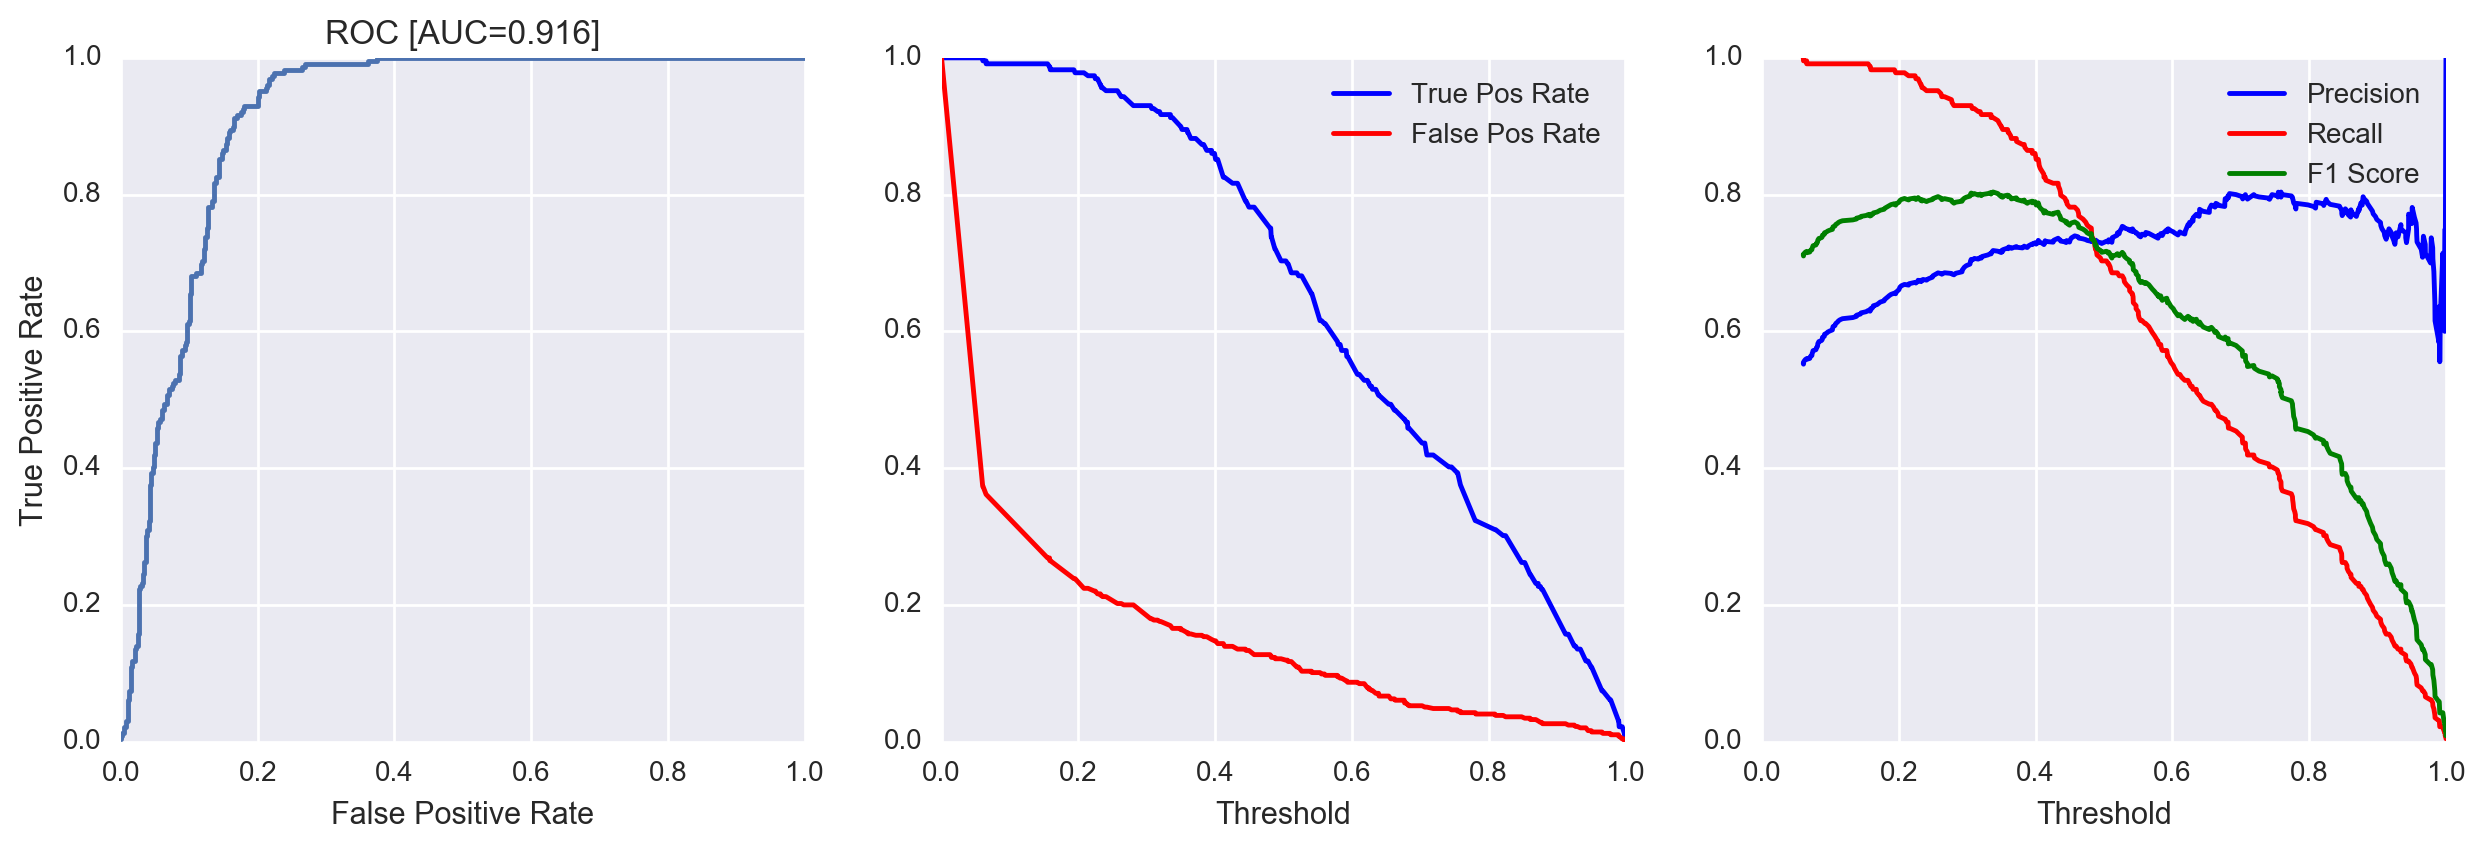

In [17]:
col = 'veteran_status'
cols_to_drop = [col]

run_lr_group(df_features_num, col, cols_to_drop)

chronic_homeless 

Dropping these columns due to fewer than 7 people having this:
 ['living_situation_before_program_entry_owned', 'living_situation_before_program_entry_permanenthousing', 'living_situation_before_program_entry_rentalother', 'health_insurance_statechild']

train (455, 66)
test (225, 66)

AUC: 0.92611
Precision: 0.5714
Recall: 0.6897
F1 score: 0.6250

Confusion Matrix
Prediction    0   1  All
Truth                   
0           181  15  196
1             9  20   29
All         190  35  225

Percent of outcomes classified
Prediction          0          1
Truth                           
0           95.263158  42.857143
1            4.736842  57.142857

As feature increases, more likely to be in positive class:
                                                        coef      odds
veteran_status                                      2.010801  7.469296
health_insurance_veteranadmin                       1.687995  5.408626
project_type_code_permanentsupportivehousing       

/Users/mattmollison/src/c4sf/datasci-sf-homeless-project/notebooks/../src/data/classify_utils.py:84: RuntimeWarning: invalid value encountered in true_divide
  f1_curve = 2*((precision_curve * recall_curve) / (precision_curve + recall_curve))


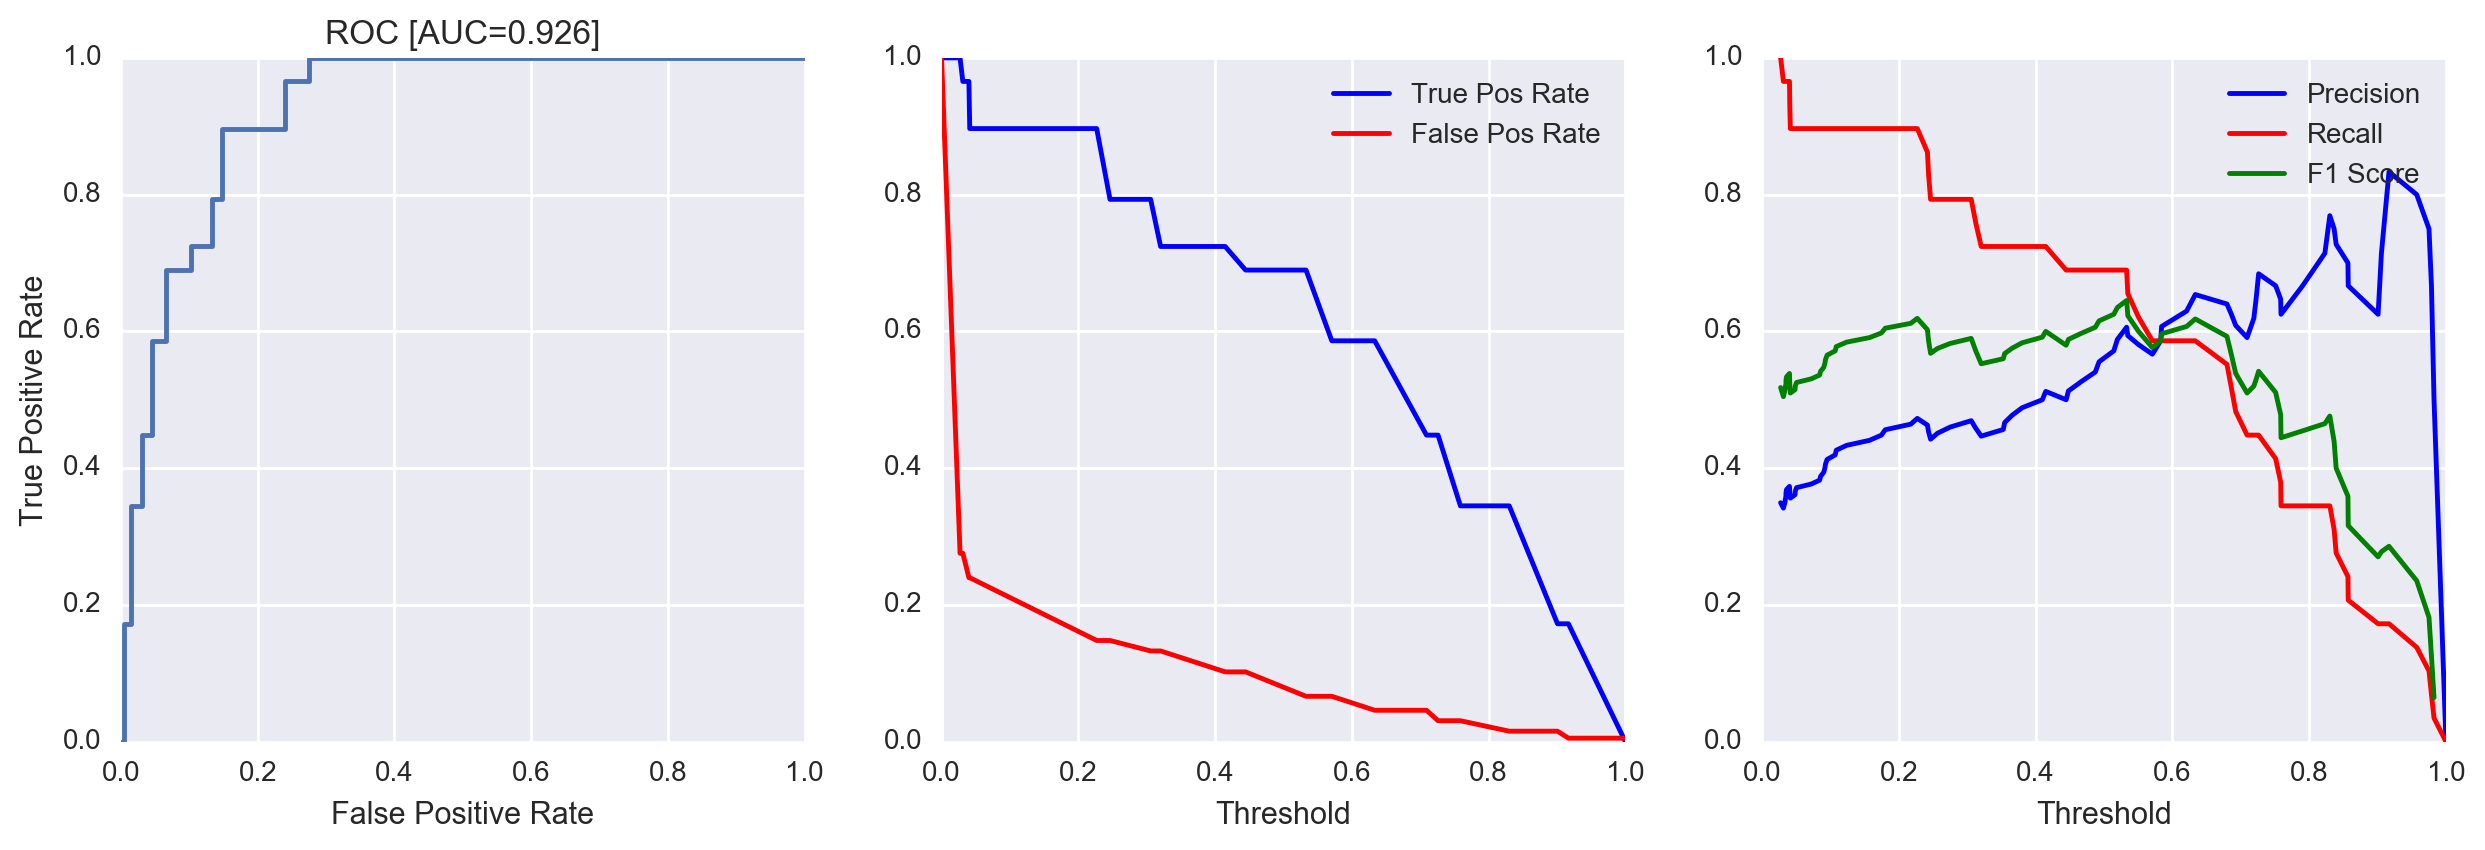

In [18]:
col = 'chronic_homeless'
cols_to_drop = [col]

run_lr_group(df_features_num, col, cols_to_drop)

continuously_homeless_one_year 

Dropping these columns due to fewer than 22 people having this:
 ['living_situation_before_program_entry_owned']

train (1411, 69)
test (696, 69)

AUC: 0.91601
Precision: 0.5660
Recall: 0.6250
F1 score: 0.5941

Confusion Matrix
Prediction    0    1  All
Truth                    
0           554   46  600
1            36   60   96
All         590  106  696

Percent of outcomes classified
Prediction          0          1
Truth                           
0           93.898305  43.396226
1            6.101695  56.603774

As feature increases, more likely to be in positive class:
                                                        coef      odds
veteran_status                                      2.273669  9.714982
project_type_code_permanentsupportivehousing        1.125828  3.082770
project_type_code_rapidrehousing                    0.903899  2.469212
project_type_code_homelessnessprevention            0.878901  2.408252
health_insurance_stateadult   

/Users/mattmollison/src/c4sf/datasci-sf-homeless-project/notebooks/../src/data/classify_utils.py:84: RuntimeWarning: invalid value encountered in true_divide
  f1_curve = 2*((precision_curve * recall_curve) / (precision_curve + recall_curve))


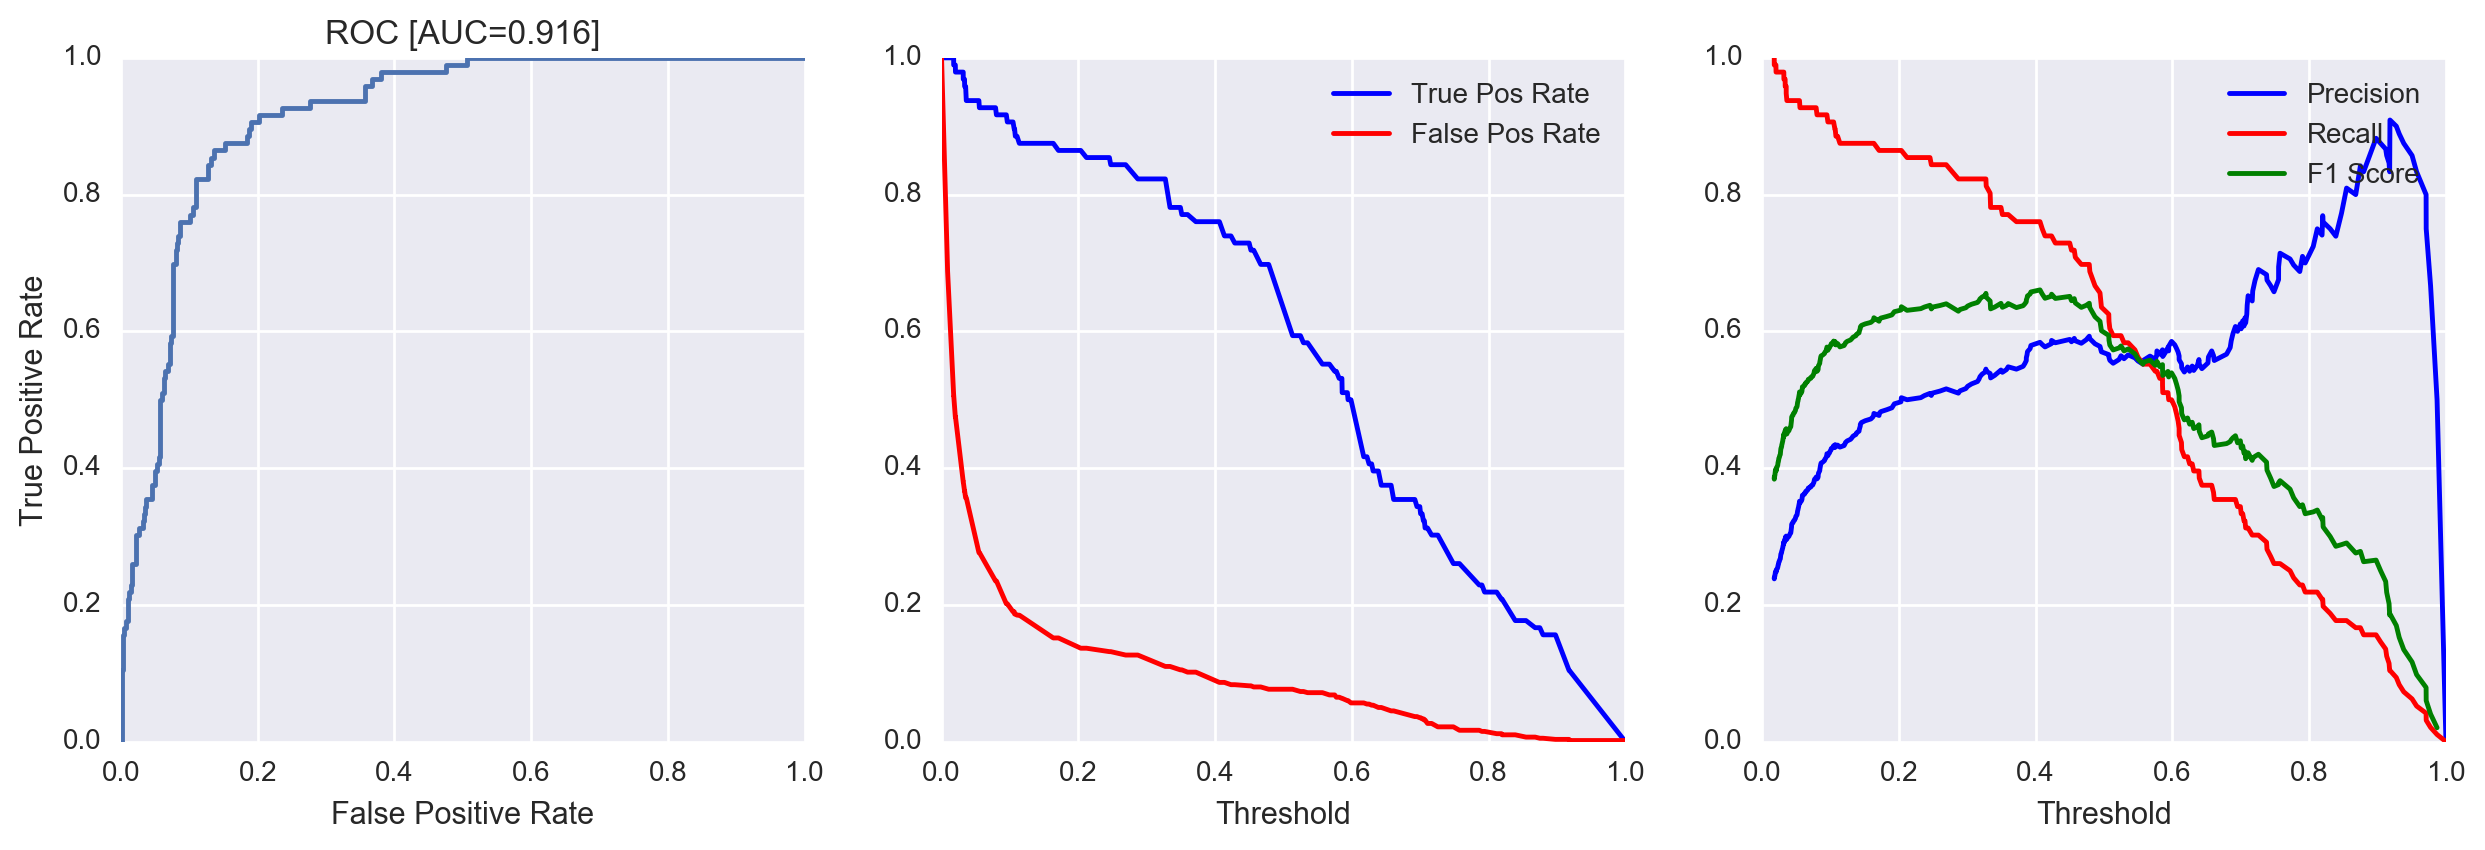

In [19]:
col = 'continuously_homeless_one_year'
cols_to_drop = [col]

run_lr_group(df_features_num, col, cols_to_drop)

disabling_condition 

Dropping these columns due to fewer than 45 people having this:
 ['living_situation_before_program_entry_permanenthousing', 'health_insurance_statechild']

train (2972, 68)
test (1465, 68)

AUC: 0.92533
Precision: 0.6623
Recall: 0.5698
F1 score: 0.6126

Confusion Matrix
Prediction     0    1   All
Truth                      
0           1234   52  1286
1             77  102   179
All         1311  154  1465

Percent of outcomes classified
Prediction          0          1
Truth                           
0           94.126621  33.766234
1            5.873379  66.233766

As feature increases, more likely to be in positive class:
                                                        coef      odds
head_of_household                                   2.203284  9.054704
project_type_code_rapidrehousing                    1.371772  3.942330
project_type_code_homelessnessprevention            1.277756  3.588578
noncash_benefit_publichousing                       1.10433

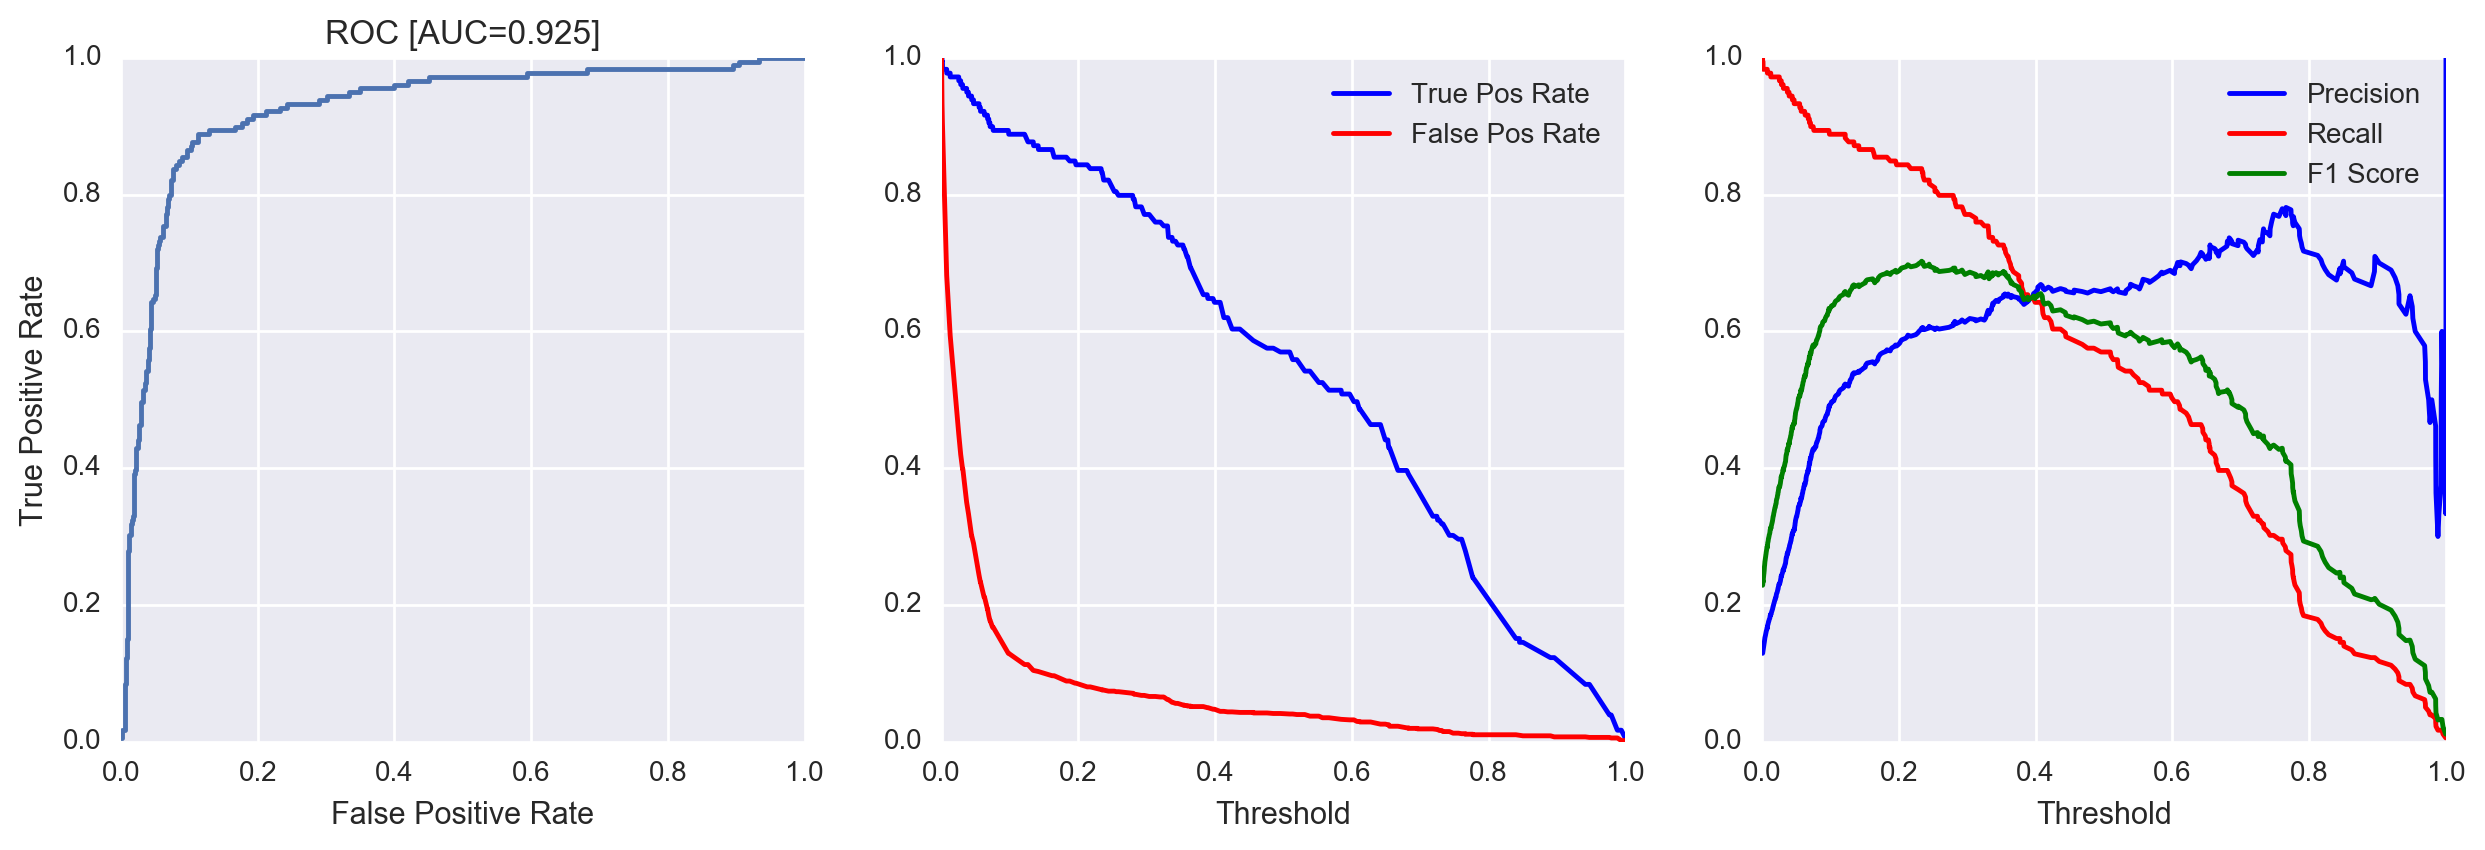

In [20]:
col = 'disabling_condition'
cols_to_drop = [col]

run_lr_group(df_features_num, col, cols_to_drop)

domestic_violence_victim 

Dropping these columns due to fewer than 21 people having this:
 ['living_situation_before_program_entry_owned', 'disability_type_hivaids']

train (1394, 68)
test (687, 68)

AUC: 0.87752
Precision: 0.6000
Recall: 0.3600
F1 score: 0.4500

Confusion Matrix
Prediction    0   1  All
Truth                   
0           656   6  662
1            16   9   25
All         672  15  687

Percent of outcomes classified
Prediction          0     1
Truth                      
0           97.619048  40.0
1            2.380952  60.0

As feature increases, more likely to be in positive class:
                                                        coef      odds
project_type_code_rapidrehousing                    1.855343  6.393893
health_insurance_stateadult                         1.321557  3.749256
continuously_homeless_one_year                      1.282640  3.606148
living_situation_before_program_entry_rentalvash    1.240817  3.458437
race_asian                        

/Users/mattmollison/src/c4sf/datasci-sf-homeless-project/notebooks/../src/data/classify_utils.py:84: RuntimeWarning: invalid value encountered in true_divide
  f1_curve = 2*((precision_curve * recall_curve) / (precision_curve + recall_curve))


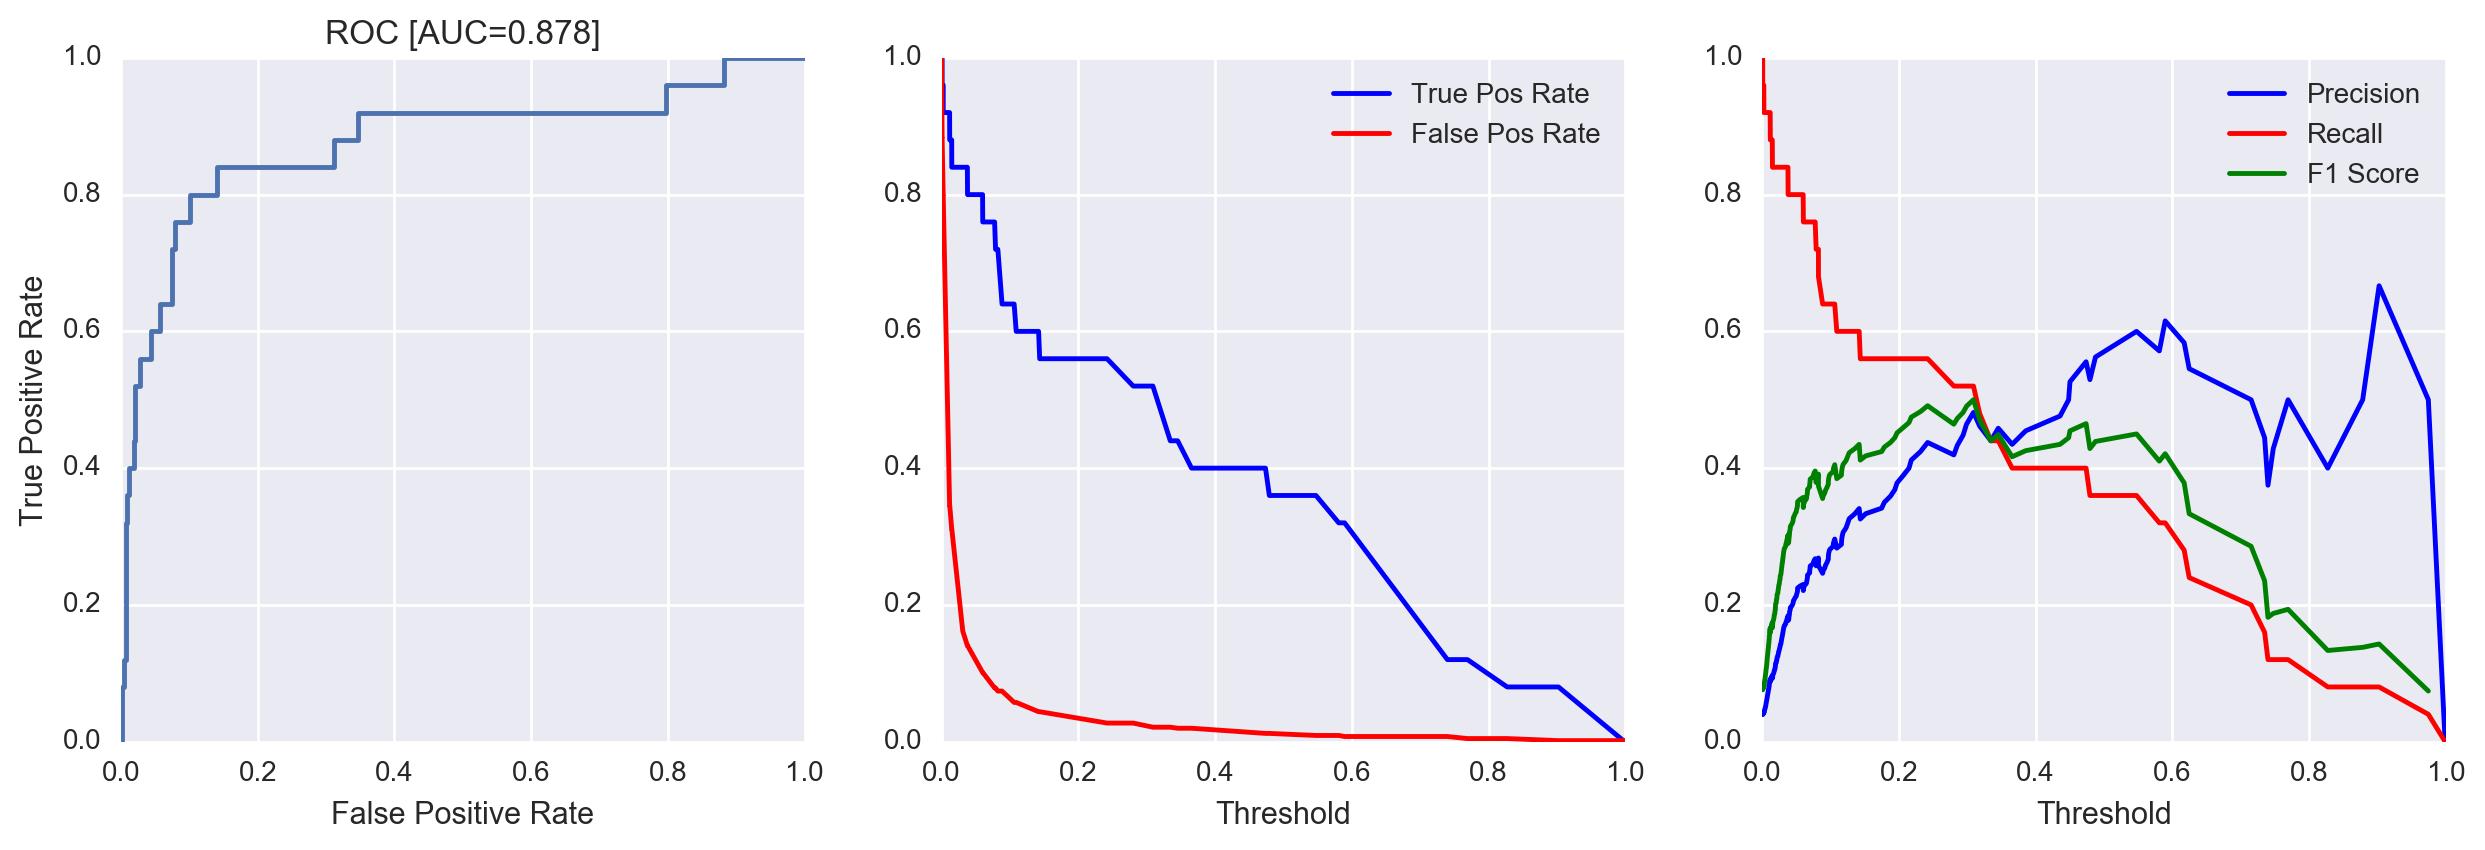

In [21]:
col = 'domestic_violence_victim'
cols_to_drop = [col]

run_lr_group(df_features_num, col, cols_to_drop)

gender_female 

Dropping these columns due to fewer than 49 people having this:
 ['disability_type_hivaids']

train (3248, 68)
test (1600, 68)

AUC: 0.88366
Precision: 0.5778
Recall: 0.2222
F1 score: 0.3210

Confusion Matrix
Prediction     0   1   All
Truth                     
0           1464  19  1483
1             91  26   117
All         1555  45  1600

Percent of outcomes classified
Prediction         0          1
Truth                          
0           94.14791  42.222222
1            5.85209  57.777778

As feature increases, more likely to be in positive class:
                                                        coef      odds
health_insurance_stateadult                         1.815119  6.141806
health_insurance_statechild                         1.507616  4.515952
project_type_code_homelessnessprevention            1.009894  2.745309
noncash_benefit_publichousing                       0.952942  2.593328
veteran_status                                      0.883622  2.4

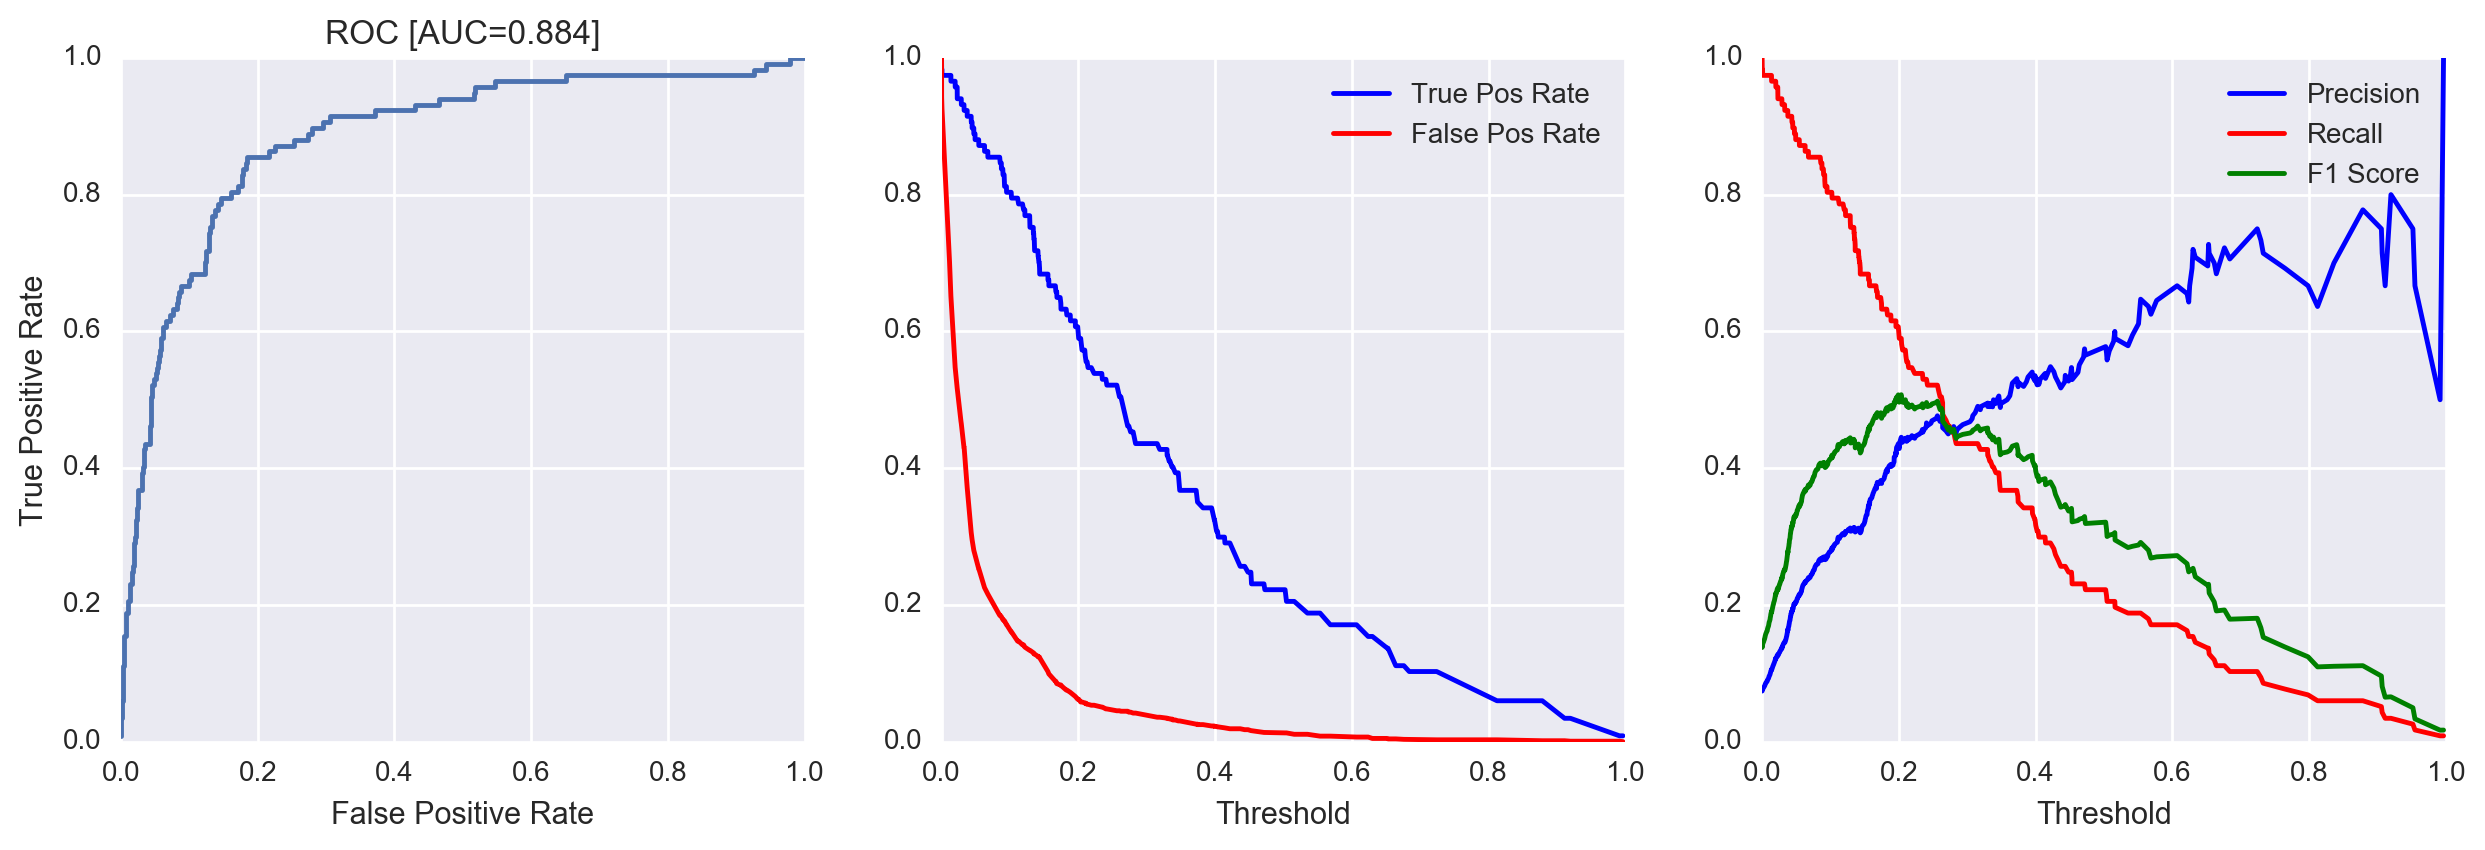

In [22]:
col = 'gender_female'
cols_to_drop = [col, 'gender_male']

run_lr_group(df_features_num, col, cols_to_drop)

gender_male 

Dropping these columns due to fewer than 66 people having this:
 ['living_situation_before_program_entry_permanenthousing']

train (4357, 68)
test (2146, 68)

AUC: 0.92582
Precision: 0.6604
Recall: 0.5323
F1 score: 0.5895

Confusion Matrix
Prediction     0    1   All
Truth                      
0           1811   72  1883
1            123  140   263
All         1934  212  2146

Percent of outcomes classified
Prediction          0          1
Truth                           
0           93.640124  33.962264
1            6.359876  66.037736

As feature increases, more likely to be in positive class:
                                                       coef      odds
health_insurance_statechild                        1.901014  6.692679
head_of_household                                  1.546894  4.696861
project_type_code_rapidrehousing                   1.400028  4.055312
project_type_code_homelessnessprevention           1.195067  3.303780
noncash_benefit_publichousing   

/Users/mattmollison/src/c4sf/datasci-sf-homeless-project/notebooks/../src/data/classify_utils.py:84: RuntimeWarning: invalid value encountered in true_divide
  f1_curve = 2*((precision_curve * recall_curve) / (precision_curve + recall_curve))


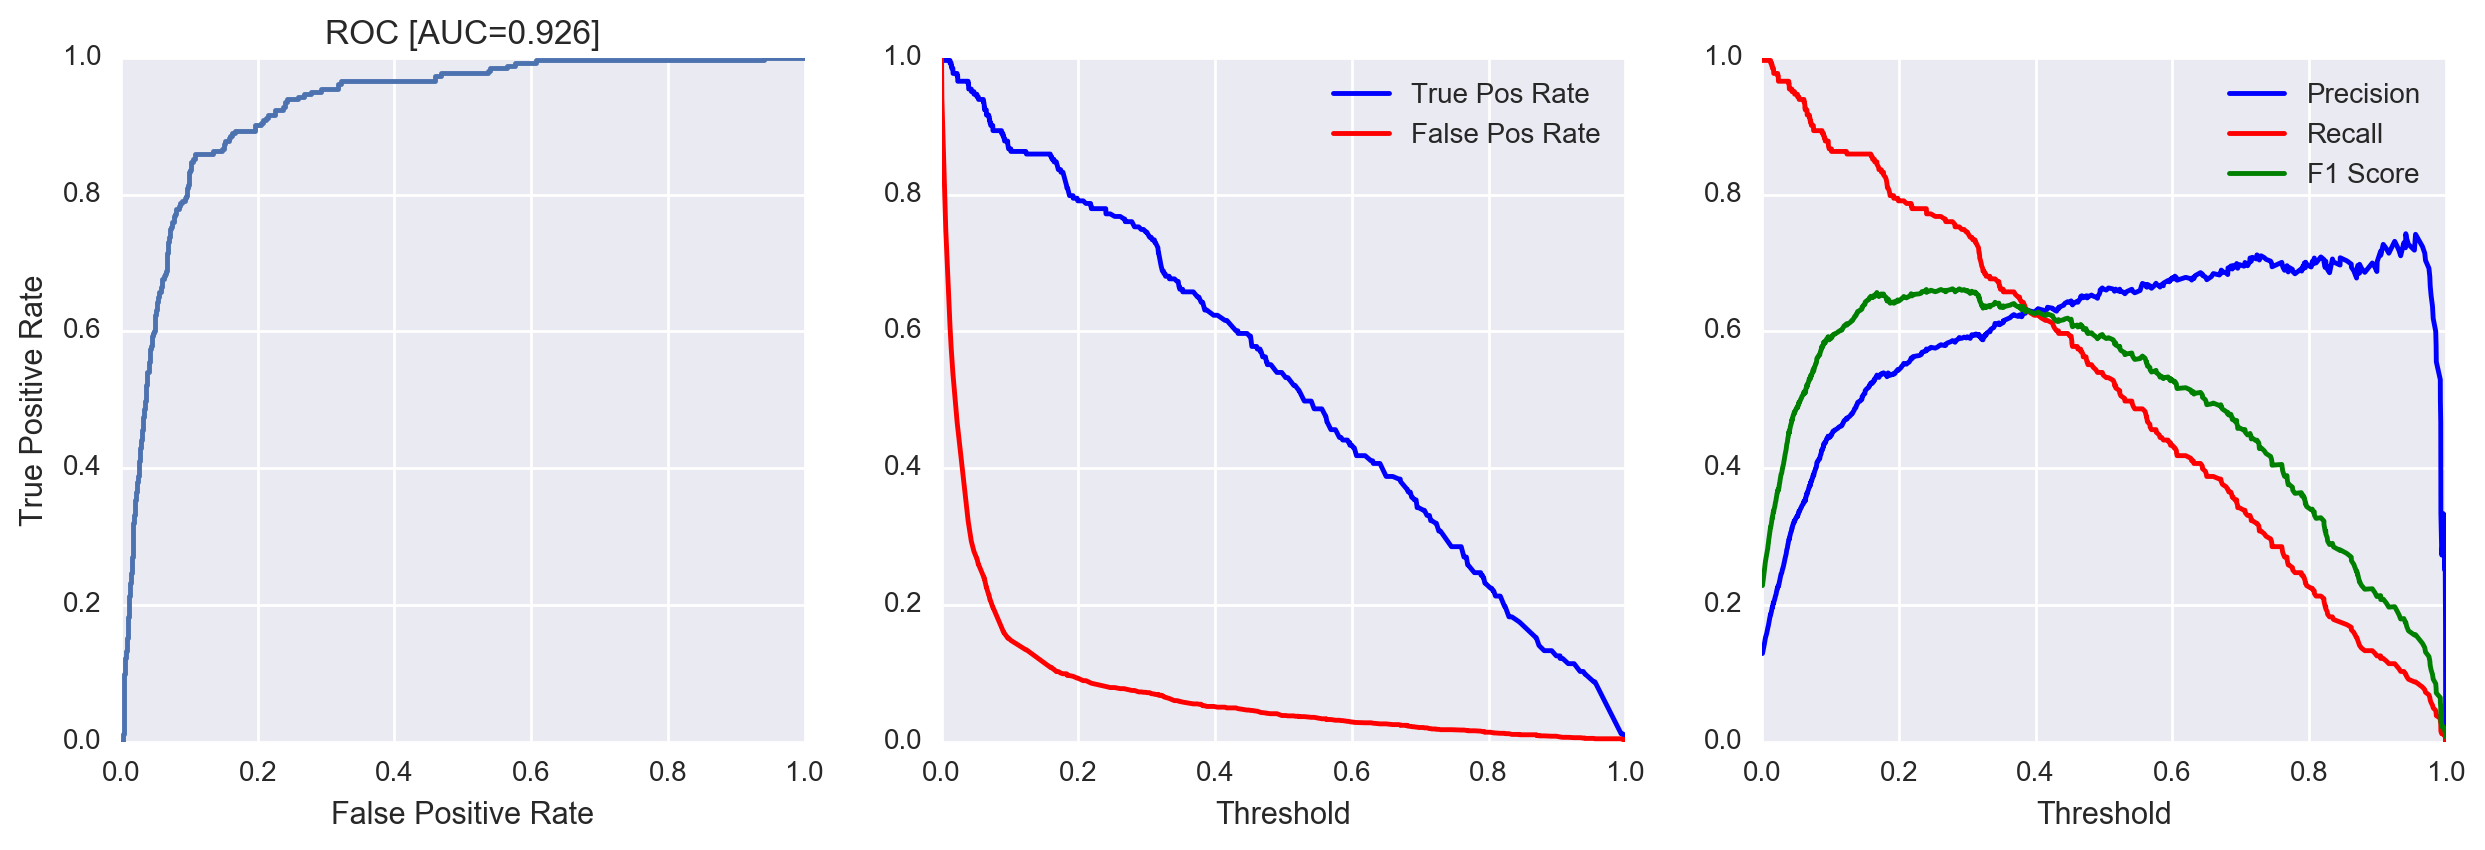

In [23]:
col = 'gender_male'
cols_to_drop = [col, 'gender_female']

run_lr_group(df_features_num, col, cols_to_drop)

ethnicity_latino 

Dropping these columns due to fewer than 53 people having this:
 ['ethnicity_unknown', 'living_situation_before_program_entry_hospitalpsych', 'race_asian', 'race_pacificisl', 'noncash_benefit_publichousing']

train (3488, 64)
test (1719, 64)

AUC: 0.91553
Precision: 0.5890
Recall: 0.3116
F1 score: 0.4076

Confusion Matrix
Prediction     0   1   All
Truth                     
0           1551  30  1581
1             95  43   138
All         1646  73  1719

Percent of outcomes classified
Prediction          0         1
Truth                          
0           94.228433  41.09589
1            5.771567  58.90411

As feature increases, more likely to be in positive class:
                                                        coef      odds
health_insurance_stateadult                         1.855348  6.393922
health_insurance_statechild                         1.365637  3.918217
project_type_code_homelessnessprevention            1.325017  3.762250
head_of_household 

/Users/mattmollison/src/c4sf/datasci-sf-homeless-project/notebooks/../src/data/classify_utils.py:84: RuntimeWarning: invalid value encountered in true_divide
  f1_curve = 2*((precision_curve * recall_curve) / (precision_curve + recall_curve))


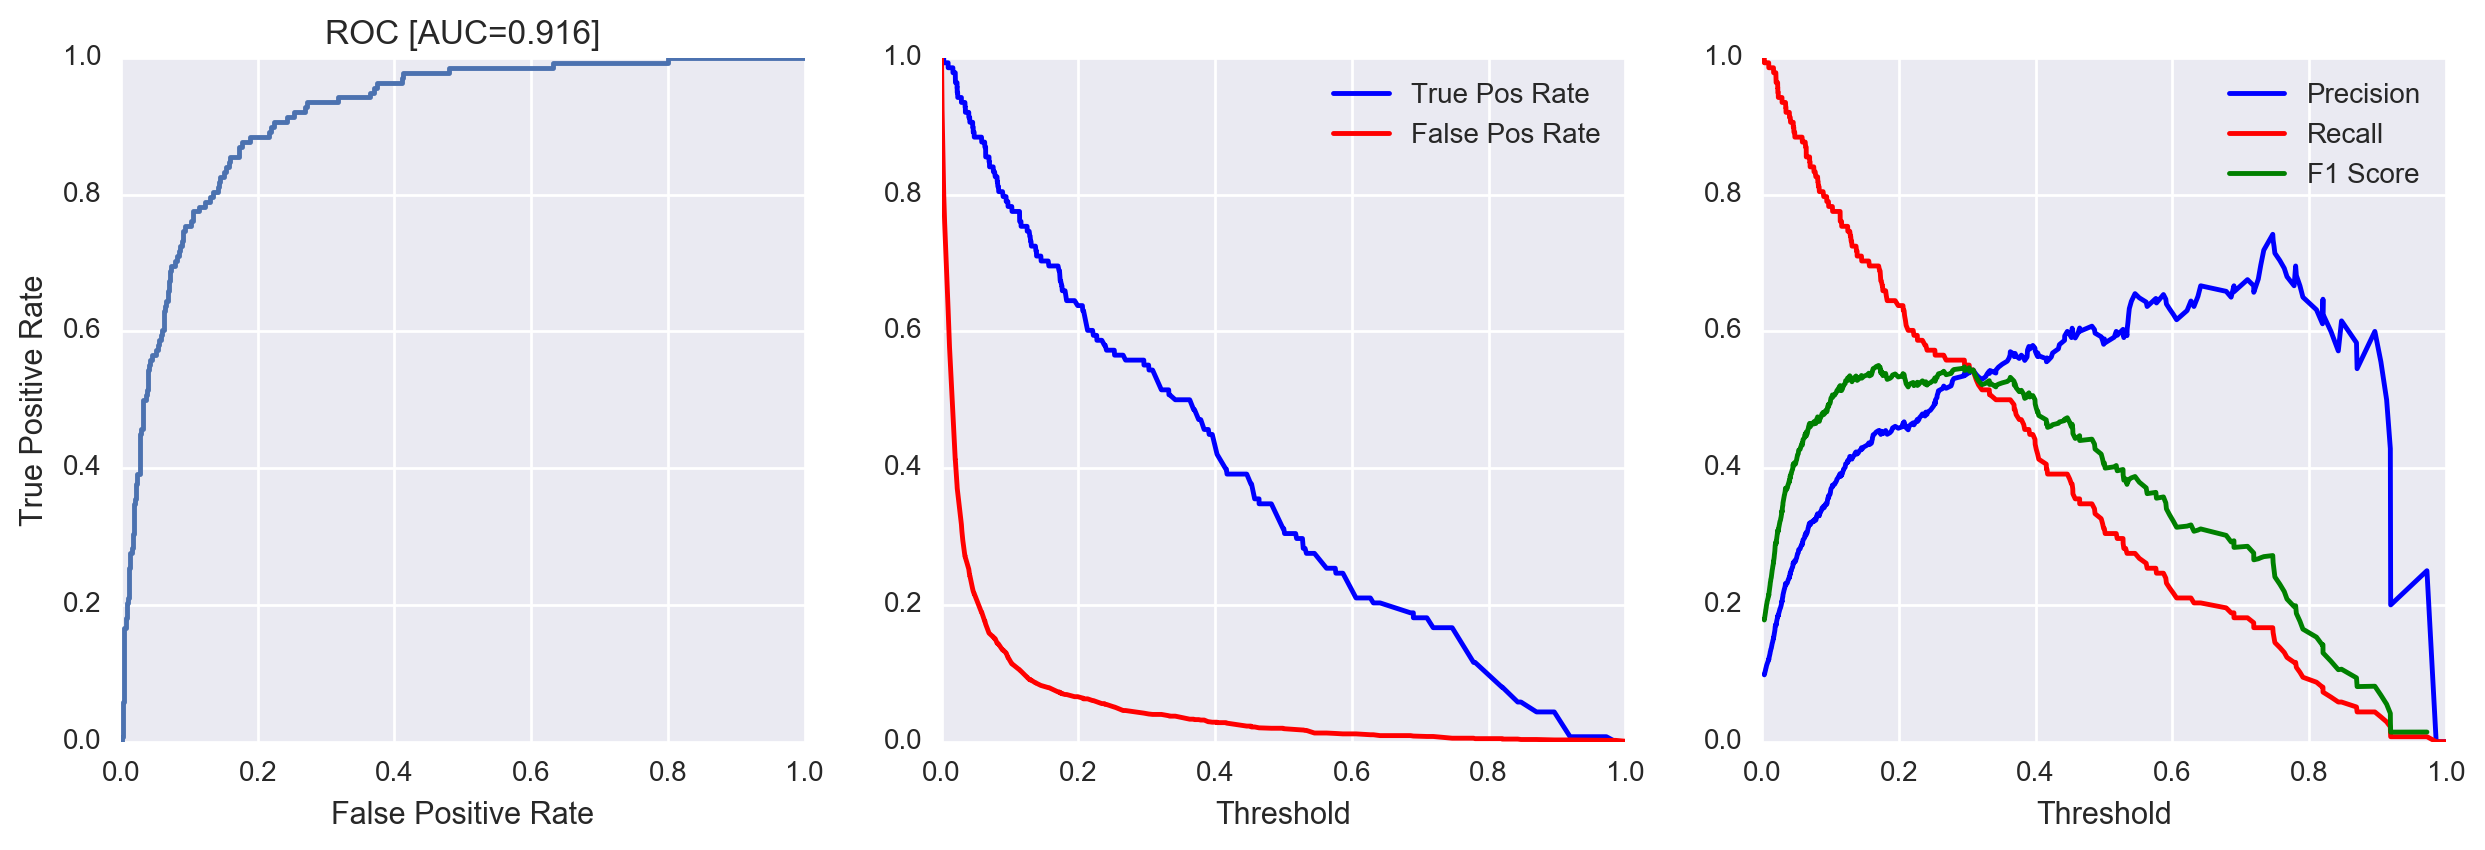

In [24]:
col = 'ethnicity_latino'
cols_to_drop = [col, 'ethnicity_nonlatino']

run_lr_group(df_features_num, col, cols_to_drop)

ethnicity_nonlatino 

Dropping these columns due to fewer than 60 people having this:
 ['ethnicity_unknown', 'living_situation_before_program_entry_owned', 'living_situation_before_program_entry_permanenthousing', 'race_unknown']

train (3972, 65)
test (1957, 65)

AUC: 0.92483
Precision: 0.6711
Recall: 0.4717
F1 score: 0.5540

Confusion Matrix
Prediction     0    1   All
Truth                      
0           1696   49  1745
1            112  100   212
All         1808  149  1957

Percent of outcomes classified
Prediction         0          1
Truth                          
0           93.80531  32.885906
1            6.19469  67.114094

As feature increases, more likely to be in positive class:
                                                       coef      odds
project_type_code_rapidrehousing                   1.488635  4.431044
head_of_household                                  1.328062  3.773724
noncash_benefit_publichousing                      1.281404  3.601693
project_type_c

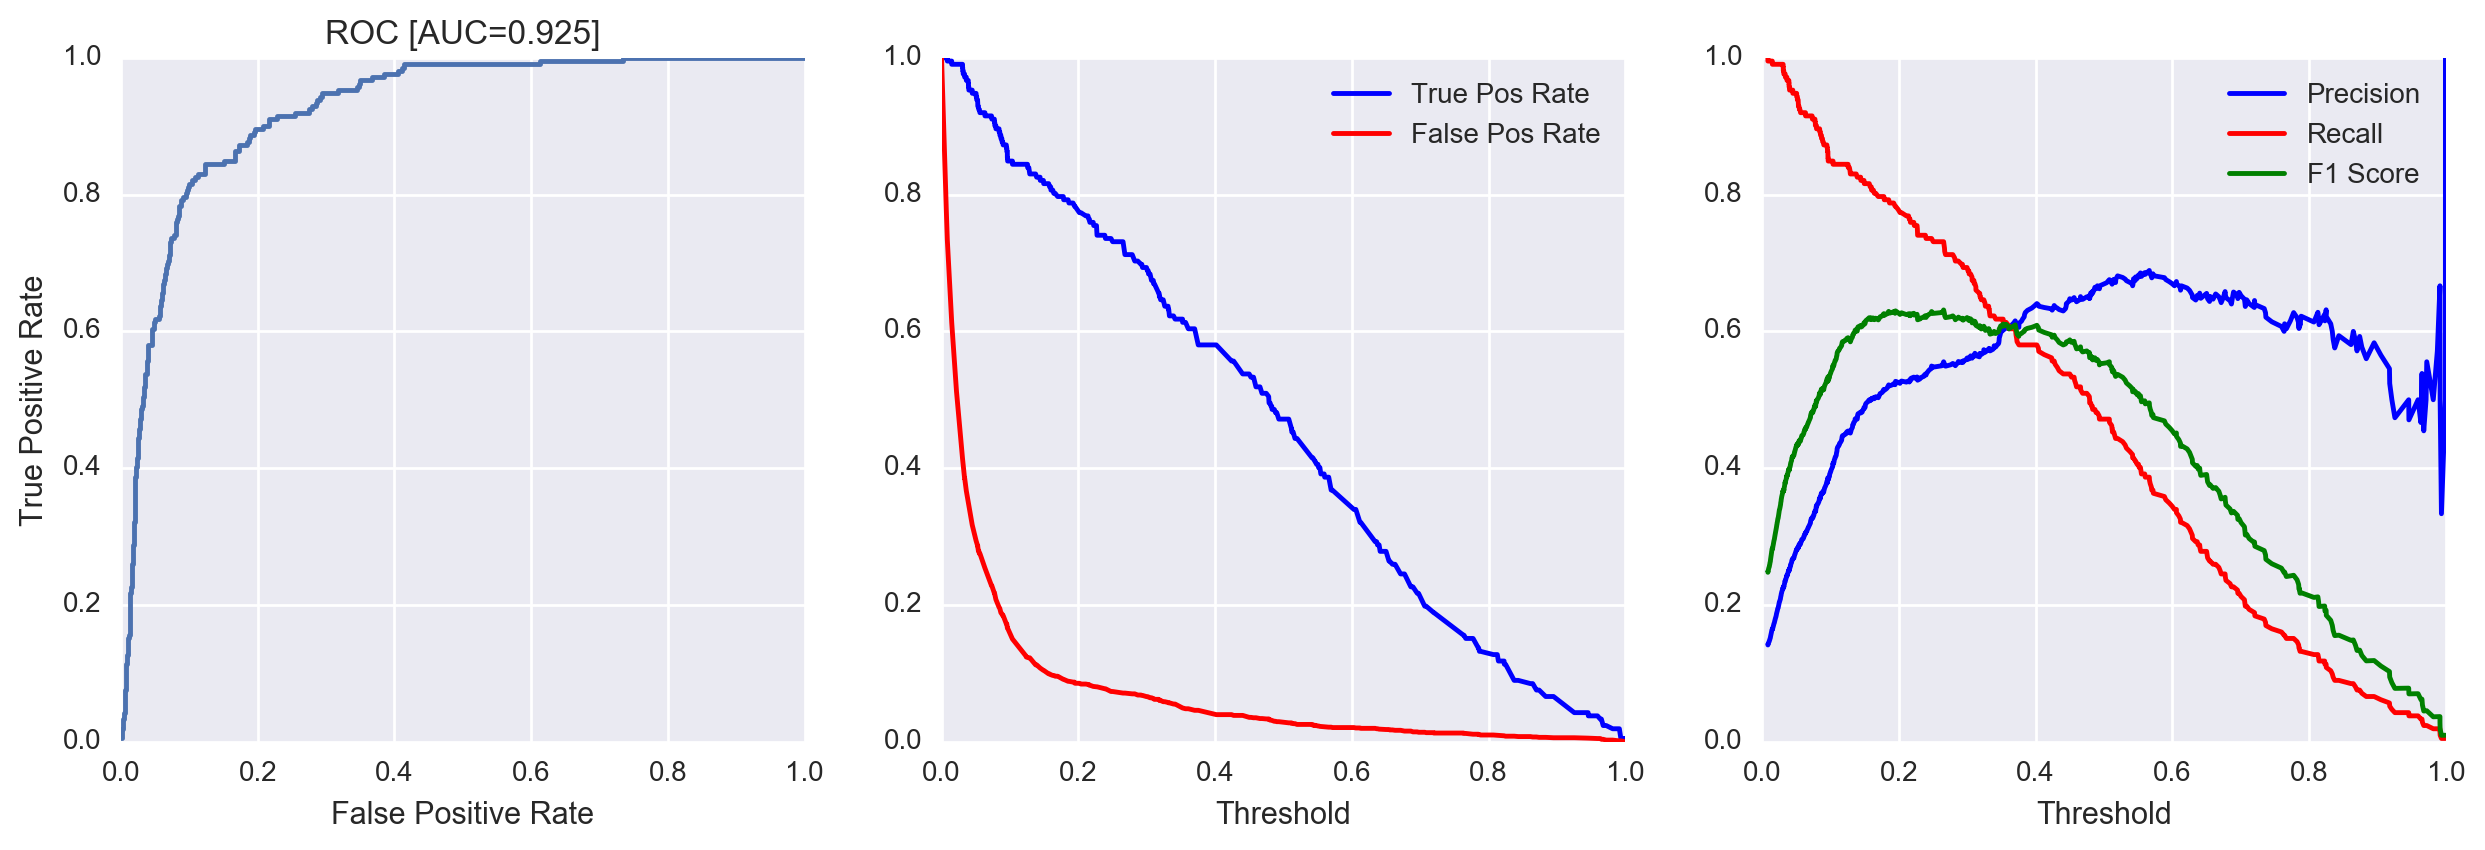

In [25]:
col = 'ethnicity_nonlatino'
cols_to_drop = [col, 'ethnicity_latino']

run_lr_group(df_features_num, col, cols_to_drop)

In [26]:
# from sklearn.model_selection import KFold

# kf = KFold(n_splits=2, shuffle=True)

# outcome = 'in_permanent_housing'
# outcome_related = ['in_permanent_housing', 'days_to_residential_move_in', 'times_in_permanent_housing']
# y = df_model_num[outcome].values
# X = df_model_num.drop(outcome_related, axis=1)

# # X = X.apply(lambda x: x.fillna(x.median()),axis=0) 

# for train_index, test_index in kf.split(X):
#     X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
#     y_train, y_test = y[train_index], y[test_index]

# print(X_train.shape)
# print(X_test.shape)

In [27]:
# results, myAuc, precision, recall, f1, myLR = cu.classify(X_train, X_test,
#                                                           y_train, y_test,
#                                                           'lr',
#                                                           print_n_features=20);

In [28]:
# results, myAuc, precision, recall, f1, myRF = cu.classify(X_train, X_test,
#                                                           y_train, y_test,
#                                                           'rf',
#                                                           n_estimators=10,
#                                                           min_samples_leaf=20,
#                                                           print_n_features=30);

In [29]:
# from sklearn import tree

# for i, tr in enumerate(myRF.estimators_):
#     tree.export_graphviz(tr, feature_names=X_train.columns, filled=True, rounded=True,
#                          class_names=['no', 'yes'],
#                          out_file='/Users/mattmollison/Desktop/trees/tree_{}.dot'.format(i))

In [30]:
# results = pd.DataFrame(myRF.feature_importances_, index=X_train.columns, columns=['importance'])
# results['std'] = np.std([tree.feature_importances_ for tree in myRF.estimators_], axis=0)

# results = results.sort_values(['importance'], ascending=False)

# results = results.iloc[:20, :]

# fig, ax = plt.subplots()
# results['importance'].iloc[::-1].plot(kind='barh', xerr=results['std'].iloc[::-1], ax=ax);

# ax.set(title='Random Forest feature importance',
#       );